In [2]:
import os
import re
import json
import jsonlines
from typing import Annotated, Optional, Literal, List, Dict, Any
from datetime import datetime, timedelta
import operator
from uuid import uuid4

from langchain.schema import Document
from langchain_experimental.text_splitter import SemanticChunker
from langchain_naver.embeddings import ClovaXEmbeddings
from langchain_milvus.vectorstores import Milvus
from langchain_naver.chat_models import ChatClovaX
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_teddynote.retrievers import KiwiBM25Retriever
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import (
    AttributeInfo,
    StructuredQueryOutputParser,
    get_query_constructor_prompt
)
from langchain.retrievers.self_query.milvus import MilvusTranslator

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from pydantic import BaseModel, Field, field_validator
import warnings

warnings.filterwarnings('ignore')

from dotenv import load_dotenv
load_dotenv()

# 기존 모델 클래스들 유지
class TimeFilter(BaseModel):
    start_date: Optional[datetime] = None
    end_date: Optional[datetime] = None

class SearchQuery(BaseModel):
    query: str
    time_filter: TimeFilter

class Label(BaseModel):
    chunk_id: int = Field(description="The unique identifier of the text chunk")
    chain_of_thought: str = Field(description="The reasoning process used to evaluate the relevance")
    relevancy: int = Field(description="Relevancy score from 0 to 10, where 10 is most relevant", ge=0, le=10)

class RerankedResults(BaseModel):
    labels: list[Label] = Field(description="List of labeled and ranked chunks")

    @field_validator("labels")
    @classmethod
    def model_validate(cls, v: list[Label]) -> list[Label]:
        return sorted(v, key=lambda x: x.relevancy, reverse=True)

# LangGraph State 정의
class AgentState(TypedDict):
    question: str
    routing_result: str
    routing_result_2: str
    expr: Optional[str]
    text_context: List[Document]
    table_context: List[Document]
    raptor_context: List[Document]
    image_context: List[Document]
    text_answer: str
    table_answer: str
    final_answer: str
    messages: Annotated[List, add_messages]

# 초기화
embeddings = ClovaXEmbeddings(model='bge-m3')
llm = ChatClovaX(model='HCX-005', temperature=0)

URI = 'http://127.0.0.1:19530'

# 데이터베이스 초기화
text_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='text_db'
)

table_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='table_db'
)

raptor_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='raptor_db'
)

image_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='image_db'
)

# BM25 리트리버 초기화
filepath_text = './chunked_jsonl/text_semantic_per_80.jsonl'
filepath_table = './chunked_jsonl/table_v7.jsonl'

def load_documents(filepath):
    docs = []
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith('\n('):
                continue
            data = json.loads(line)
            doc = Document(
                page_content=data['page_content'],
                metadata=data['metadata']
            )
            docs.append(doc)
    return docs

splitted_doc_text = load_documents(filepath_text)
splitted_doc_table = load_documents(filepath_table)

bm25_retriever_text = KiwiBM25Retriever.from_documents(splitted_doc_text)
bm25_retriever_text.k = 50

bm25_retriever_table = KiwiBM25Retriever.from_documents(splitted_doc_table)
bm25_retriever_table.k = 20

# 유틸리티 함수들 (기존 코드 유지)
def adjust_time_filter_to_week(time_filter):
    start_date = time_filter.start_date
    end_date = time_filter.end_date

    if start_date is None or end_date is None:
        if start_date is not None and end_date is None:
            start_of_week = start_date - timedelta(days=start_date.weekday())
            end_of_week = start_of_week + timedelta(days=6)
            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        elif end_date is not None and start_date is None:
            start_of_week = end_date - timedelta(days=end_date.weekday())
            end_of_week = start_of_week + timedelta(days=6)
            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        else:
            return None

    if start_date.year == end_date.year and start_date.month == end_date.month and start_date.day == end_date.day:
        start_of_week = start_date - timedelta(days=start_date.weekday())
        end_of_week = start_of_week + timedelta(days=6)
        return {
            "start_date": start_of_week.replace(hour=0, minute=0, second=0),
            "end_date": end_of_week.replace(hour=23, minute=59, second=59)
        }

    return {"start_date": start_date, "end_date": end_date}

def parse_search_query_response(response: str, question: str) -> SearchQuery:
    try:
        data = json.loads(response.content)
        if data.get("time_filter") is None:
            data["time_filter"] = {}
        if "query" not in data:
            data["query"] = question
        return SearchQuery(**data)
    except Exception:
        return SearchQuery(query=question, time_filter=TimeFilter())

def format_docs(docs):
    return "\n\n".join(
        f"Issue Date: {doc.metadata.get('issue_date', 'Unknown')}\nContent: {doc.page_content}"
        for doc in docs
    )

# LangGraph 노드 함수들
def extract_date_node(state: AgentState) -> AgentState:
    """날짜 추출 노드"""
    question = state["question"]
    today = datetime(2025, 1, 25)
    days_since_last_friday = (today.weekday() - 4) % 7
    last_friday = today - timedelta(days=days_since_last_friday)
    issue_date = last_friday.strftime("%Y-%m-%d")

    system_prompt = f"""
    You are an AI assistant that extracts date ranges from financial queries.
    The current report date is {issue_date}.
    Your task is to extract the relevant date or date range from the user's query
    and format it in YYYY-MM-DD format.
    If no date is specified, answer with None value.
    Return your answer as a JSON object in this format:
    {{
        "query": "<원본 질문>",
        "time_filter": {{"start_date": "YYYY-MM-DD", "end_date": "YYYY-MM-DD"}} or {{"start_date": null, "end_date": null}}
    }}
    답변은 반드시 위 JSON 형태로만 해.
    """

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question},
    ]
    
    response = llm.invoke(messages)
    search_query = parse_search_query_response(response, question)
    parsed_dates = adjust_time_filter_to_week(search_query.time_filter)

    if parsed_dates:
        start = parsed_dates['start_date']
        end = parsed_dates['end_date']
        expr = f"issue_date >= '{start.strftime('%Y%m%d')}' AND issue_date <= '{end.strftime('%Y%m%d')}'"
    else:
        expr = None

    return {"expr": expr}

def routing_node(state: AgentState) -> AgentState:
    """라우팅 노드 - 요약/예측/일반 분류"""
    question = state["question"]
    
    prompt = PromptTemplate.from_template(
        '''주어진 사용자 질문을 `요약`, `예측`, 또는 `일반` 중 하나로 분류하세요. 한 단어 이상으로 응답하지 마세요.
        
        <question>
        {question}
        </question>
        
        Classification:'''
    )
    
    messages = [{"role": "user", "content": prompt.format(question=question)}]
    response = llm.invoke(messages)
    
    return {"routing_result": response.content.strip()}

def routing_2_node(state: AgentState) -> AgentState:
    """라우팅 노드 2 - 날짜/호수 분류"""
    question = state["question"]
    
    prompt = PromptTemplate.from_template(
        '''주어진 사용자 질문을 `날짜`, `호수` 중 하나로 분류하세요. 한 단어 이상으로 응답하지 마세요.
        
        <question>
        {question}
        </question>
        
        Classification:'''
    )
    
    messages = [{"role": "user", "content": prompt.format(question=question)}]
    response = llm.invoke(messages)
    
    return {"routing_result_2": response.content.strip()}

def text_retrieval_node(state: AgentState) -> AgentState:
    """텍스트 검색 노드"""
    question = state["question"]
    expr = state.get("expr")
    
    if expr:
        context_raw = text_db.as_retriever(
            search_kwargs={'expr': expr, 'k': 25}
        ).invoke(question)
    else:
        context_raw = text_db.as_retriever(search_kwargs={'k': 25}).invoke(question)
    
    return {"text_context": context_raw}

def table_retrieval_node(state: AgentState) -> AgentState:
    """테이블 검색 노드"""
    question = state["question"]
    expr = state.get("expr")
    
    # Milvus 검색
    if expr:
        milvus_results = table_db.as_retriever(
            search_kwargs={'expr': expr, 'k': 10}
        ).invoke(question)
    else:
        milvus_results = table_db.as_retriever(search_kwargs={'k': 10}).invoke(question)
    
    # BM25 검색
    bm25_raw = bm25_retriever_table.invoke(question)
    
    # 날짜 필터링
    if expr:
        start_date = expr.split("'")[1]
        end_date = expr.split("'")[3]
        bm25_filtered = [
            doc for doc in bm25_raw
            if start_date <= doc.metadata.get("issue_date", "") <= end_date
        ]
    else:
        bm25_filtered = bm25_raw
    
    combined_context = milvus_results + bm25_filtered
    
    return {"table_context": combined_context}

def raptor_retrieval_node(state: AgentState) -> AgentState:
    """RAPTOR 검색 노드"""
    question = state["question"]
    expr = state.get("expr")
    routing_result_2 = state.get("routing_result_2", "")
    
    if '날짜' in routing_result_2.lower() and expr:
        context = raptor_db.as_retriever(
            search_kwargs={'expr': expr, 'k': 10}
        ).invoke(question)
    else:
        # Self-query retriever 사용
        metadata_field_info = [
            AttributeInfo(
                name='source',
                description='문서의 번호. 네 자리의 숫자와 "호"로 이루어져 있다. 현재 1090호부터 1120호까지 존재한다.',
                type='string',
            ),
        ]
        
        prompt_query = get_query_constructor_prompt(
            'summary of weekly financial report about bonds',
            metadata_field_info
        )
        
        output_parser = StructuredQueryOutputParser.from_components()
        query_constructor = prompt_query | llm | output_parser
        
        retriever_raptor = SelfQueryRetriever(
            query_constructor=query_constructor,
            vectorstore=raptor_db,
            structured_query_translator=MilvusTranslator(),
            search_kwargs={'k': 10}
        )
        
        context = retriever_raptor.invoke(question)
    
    return {"raptor_context": context}

def text_answer_node(state: AgentState) -> AgentState:
    """텍스트 답변 생성 노드"""
    question = state["question"]
    context = state["text_context"]
    
    text_prompt = PromptTemplate.from_template(
        '''today is '2025-01-25'. You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just say that you don't know.
        If question has date expressions, context already filtered with the date expression, so ignore about the date and answer without it.
        Answer in Korean. Answer in detail.

        #Question:
        {question}
        #Context:
        {context}

        #Answer:'''
    )
    
    formatted_context = format_docs(context)
    messages = [{"role": "user", "content": text_prompt.format(question=question, context=formatted_context)}]
    response = llm.invoke(messages)
    
    return {"text_answer": response.content}

def table_answer_node(state: AgentState) -> AgentState:
    """테이블 답변 생성 노드"""
    question = state["question"]
    context = state["table_context"]
    
    table_prompt = PromptTemplate.from_template(
        '''You are an assistant for question-answering tasks.
        Use the following pieces of retrieved table to answer the question.
        If you don't know the answer, just say that you don't know.
        Answer in Korean. Answer in detail.

        #Question:
        {question}
        #Context:
        {context}

        #Answer:'''
    )
    
    formatted_context = format_docs(context)
    messages = [{"role": "user", "content": table_prompt.format(question=question, context=formatted_context)}]
    response = llm.invoke(messages)
    
    return {"table_answer": response.content}

def raptor_answer_node(state: AgentState) -> AgentState:
    """RAPTOR 답변 생성 노드"""
    question = state["question"]
    context = state["raptor_context"]
    
    raptor_prompt = PromptTemplate.from_template(
        '''You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just say that you don't know.
        Answer in Korean. Answer in detail.
        If the context mentions an unrelated date, do not mention that part.
        Summarize and organize your answers based on the various issues that apply to the period.

        #Question:
        {question}
        #Context:
        {context}

        #Answer:'''
    )
    
    formatted_context = format_docs(context)
    messages = [{"role": "user", "content": raptor_prompt.format(question=question, context=formatted_context)}]
    response = llm.invoke(messages)
    
    return {"final_answer": response.content}

def general_answer_node(state: AgentState) -> AgentState:
    """일반 답변 생성 노드"""
    question = state["question"]
    text_answer = state["text_answer"]
    table_answer = state["table_answer"]
    
    general_prompt = PromptTemplate.from_template(
        '''You are question-answering AI chatbot about financial reports.
        주어진 두 개의 정보는 table과 text에서 가져온 정보들이야. 이 정보를 바탕으로 질문에 대해 자세히 설명해줘.
        
        If one of the table or text says it doesn't know or it can't answer, don't mention with that.
        And some questions may not be answered simply with context, but rather require inference. In those cases, answer by inference. 
        
        #Question:
        {question}

        #Text Answer:
        {text}

        #Table Answer:
        {table}
        '''
    )
    
    messages = [{"role": "user", "content": general_prompt.format(question=question, text=text_answer, table=table_answer)}]
    response = llm.invoke(messages)
    
    return {"final_answer": response.content}

def predict_answer_node(state: AgentState) -> AgentState:
    """예측 답변 생성 노드 (일반 답변과 동일한 로직)"""
    return general_answer_node(state)

# 조건부 엣지 함수들
def should_use_summary(state: AgentState) -> str:
    """요약 경로인지 확인"""
    routing_result = state.get("routing_result", "").lower()
    if '요약' in routing_result:
        return "routing_2"
    elif '예측' in routing_result:
        return "predict_flow"
    else:
        return "general_flow"

def should_use_date_routing(state: AgentState) -> str:
    """날짜 기반 라우팅인지 확인"""
    routing_result_2 = state.get("routing_result_2", "").lower()
    if '날짜' in routing_result_2:
        return "raptor_answer"
    else:
        return "raptor_answer"


# 그래프 구축
def create_langgraph_agent():
    """LangGraph 에이전트 생성"""
    
    workflow = StateGraph(AgentState)
    
    # 노드 추가 (상태 키와 다른 이름 사용)
    workflow.add_node("extract_date", extract_date_node)
    workflow.add_node("routing", routing_node)
    workflow.add_node("routing_2", routing_2_node)
    workflow.add_node("text_retrieval", text_retrieval_node)
    workflow.add_node("table_retrieval", table_retrieval_node)
    workflow.add_node("raptor_retrieval", raptor_retrieval_node)
    workflow.add_node("text_answer_node", text_answer_node)
    workflow.add_node("table_answer_node", table_answer_node)
    workflow.add_node("raptor_answer_node", raptor_answer_node)
    workflow.add_node("general_answer_node", general_answer_node)
    workflow.add_node("predict_answer_node", predict_answer_node)

    def choose_final_answer(state: AgentState) -> str:
        """라우팅 결과에 따른 최종 답변 노드 선택"""
        routing_result = state.get("routing_result", "").lower()
        if '예측' in routing_result:
            return "predict_answer"
        else:
            return "general_answer"
    
    # 엣지 연결
    workflow.add_edge(START, "extract_date")
    workflow.add_edge("extract_date", "routing")
    
    workflow.add_conditional_edges(
        "routing",
        should_use_summary,
        {
            "routing_2": "routing_2",
            "predict_flow": "text_retrieval",
            "general_flow": "text_retrieval"
        }
    )
    
    workflow.add_conditional_edges(
        "routing_2",
        should_use_date_routing,
        {
            "raptor_answer": "raptor_retrieval"
        }
    )
    
    workflow.add_edge("raptor_retrieval", "raptor_answer_node")
    workflow.add_edge("raptor_answer_node", END)
    
    workflow.add_edge("text_retrieval", "table_retrieval")
    workflow.add_edge("table_retrieval", "text_answer_node")
    workflow.add_edge("text_answer_node", "table_answer_node")
    
    workflow.add_conditional_edges(
        "table_answer_node",
        choose_final_answer,
        {
            "predict_answer": "predict_answer_node",
            "general_answer": "general_answer_node"
        }
    )
    
    workflow.add_edge("general_answer_node", END)
    workflow.add_edge("predict_answer_node", END)
    
    return workflow.compile()


# 사용 예시
def ask_langgraph(question: str):
    """LangGraph 기반 질문 응답 함수"""
    agent = create_langgraph_agent()
    
    # 초기 상태 설정
    initial_state = {
        "question": question,
        "messages": []
    }
    
    # 그래프 실행
    result = agent.invoke(initial_state)
    
    return result["final_answer"]

# 메인 실행 함수
if __name__ == "__main__":
    # 예시 실행
    question = "연준의 비공식 대변인은?"
    answer = ask_langgraph(question)
    print(answer)


연준의 비공식 대변인은 월스트리트저널(WSJ)의 닉 티미라오스(Nick Timiraos) 기자로 알려져 있습니다.

이는 텍스트 답변에 명시되어 있으며, 일반적으로 금융 및 경제 분야에서 신뢰받는 출처 중 하나인 WSJ 소속 기자의 발언은 종종 중요한 인사이트를 제공하기 때문에 이러한 인식이 형성되었을 가능성이 높습니다. 다만, 공식적인 대변인 역할이 아니기 때문에 그의 의견이나 보도가 항상 연준의 입장을 대변하는 것은 아니라는 점을 유의해야 합니다.

한편, 테이블 답변에서는 해당 정보가 제공되지 않아 답변을 드릴 수 없다고 나와있습니다. 이는 테이블에 저장된 특정 데이터베이스나 정보 소스에서 연준의 비공식 대변인에 관한 세부 사항을 찾을 수 없음을 의미하며, 이 경우 외부 출처를 통해 얻은 지식을 활용하여 답변을 제공하는 것이 적절하다고 판단됩니다.


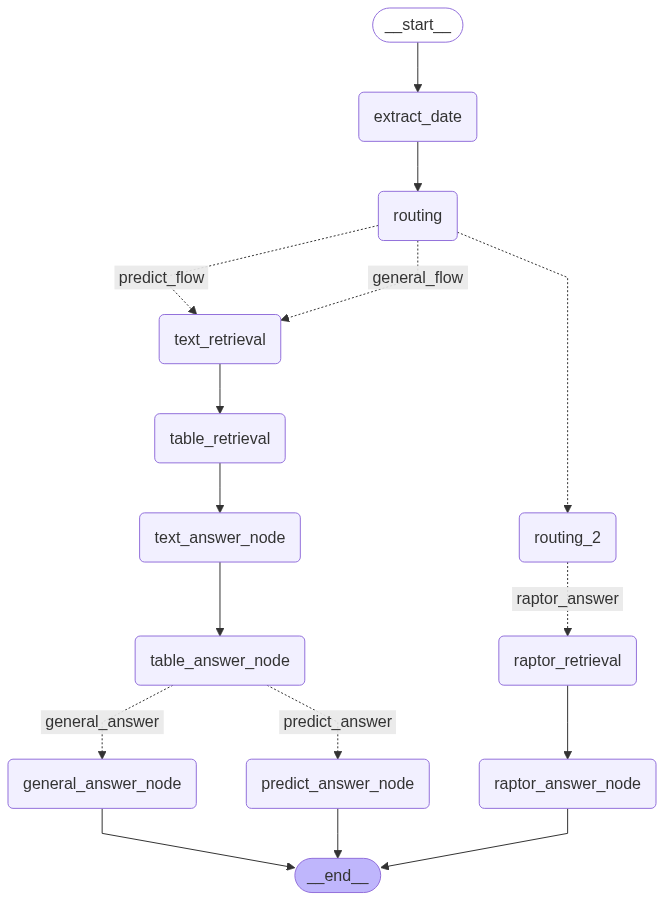

In [4]:
create_langgraph_agent()

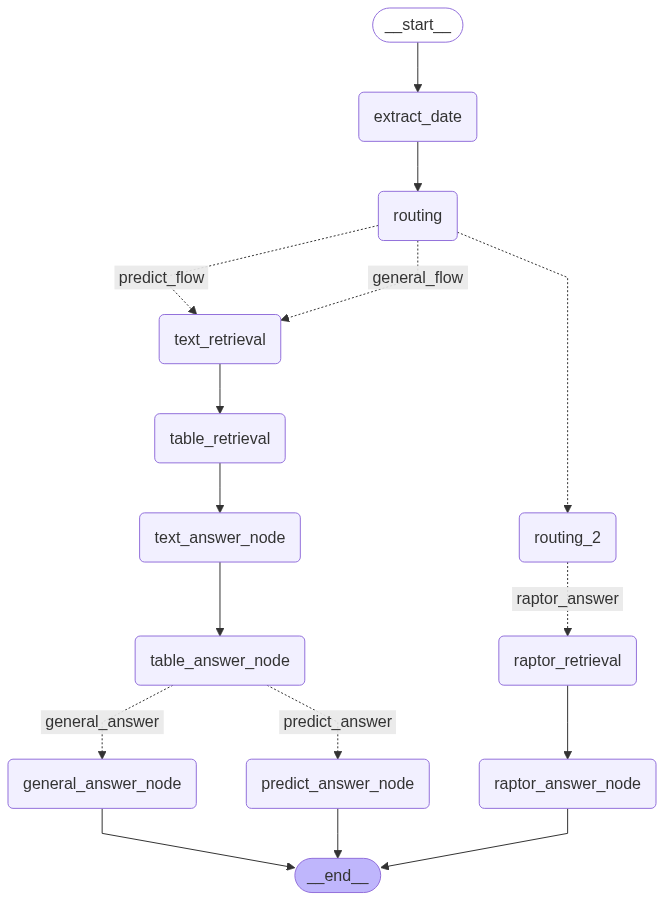

In [5]:
from IPython.display import Image, display

display(Image(create_langgraph_agent().get_graph().draw_mermaid_png()))